# Spherical cap fitting for AFM data
#### Tan Beng Hau and An Hongjie, Cavitation Lab

This is a simple code to perform a least squares fit to a spherical cap. The data we use is from an atomic force microscopy (AFM) scan of a tiny nanobubble that sits on an atomically flat surface. 

Rather than try to manually track where the substrate ends and the bubble starts, we used a code by Marcos Duarte (https://github.com/demotu) to track the gradient of the surface height. The surface height was averaged with a sliding window of variable size. 

The bubble contour is then fitted to a spherical cap using a least squares fit -- this code is taken from the Scipy Cookbook. 

To recover the contact angle, note that a spherical cap is described by 

$$ \theta = \arcsin L/R. $$

In [1]:
from scipy import *
from scipy.optimize import leastsq
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def readFile(filename, windowSize): 
    header_row = ['x', 'h']
    data = pd.read_csv(filename, delimiter='\t', names=header_row)
    data = data[1:]
    roll_mean = pd.rolling_mean(data['h'], window = windowSize).values
    return double(data['x'].values), double(data['h'].values) - double(data['h'].values.min()), roll_mean

In [3]:
"""This code to detect the peaks is courtesy of Marcos Duarte."""

from __future__ import division, print_function
import numpy as np

def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):

    """Detect peaks in data based on their amplitude and other features.

    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height.
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).
    kpsh : bool, optional (default = False)
        keep peaks with same height even if they are closer than `mpd`.
    valley : bool, optional (default = False)
        if True (1), detect valleys (local minima) instead of peaks.
    show : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.

    Notes
    -----
    The detection of valleys instead of peaks is performed internally by simply
    negating the data: `ind_valleys = detect_peaks(-x)`
    
    The function can handle NaN's 

    See this IPython Notebook [1]_.

    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb

    Examples
    --------
    >>> from detect_peaks import detect_peaks
    >>> x = np.random.randn(100)
    >>> x[60:81] = np.nan
    >>> # detect all peaks and plot data
    >>> ind = detect_peaks(x, show=True)
    >>> print(ind)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # set minimum peak height = 0 and minimum peak distance = 20
    >>> detect_peaks(x, mph=0, mpd=20, show=True)

    >>> x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
    >>> # set minimum peak distance = 2
    >>> detect_peaks(x, mpd=2, show=True)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # detection of valleys instead of peaks
    >>> detect_peaks(x, mph=0, mpd=20, valley=True, show=True)

    >>> x = [0, 1, 1, 0, 1, 1, 0]
    >>> # detect both edges
    >>> detect_peaks(x, edge='both', show=True)

    >>> x = [-2, 1, -2, 2, 1, 1, 3, 0]
    >>> # set threshold = 2
    >>> detect_peaks(x, threshold = 2, show=True)
    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind


def _plot(x, mph, mpd, threshold, edge, valley, ax, ind):
    """Plot results of the detect_peaks function, see its help."""
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(8, 4))

        ax.plot(x, 'b', lw=1)
        if ind.size:
            label = 'valley' if valley else 'peak'
            label = label + 's' if ind.size > 1 else label
            ax.plot(ind, x[ind], '+', mfc=None, mec='r', mew=2, ms=8,
                    label='%d %s' % (ind.size, label))
            ax.legend(loc='best', framealpha=.5, numpoints=1)
        ax.set_xlim(-.02*x.size, x.size*1.02-1)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax.set_xlabel('Data #', fontsize=14)
        ax.set_ylabel('Amplitude', fontsize=14)
        mode = 'Valley detection' if valley else 'Peak detection'
        ax.set_title("%s (mph=%s, mpd=%d, threshold=%s, edge='%s')"
                     % (mode, str(mph), mpd, str(threshold), edge))
        # plt.grid()
        plt.show()


In [4]:
def fitting(q):

    vector = abs(nan_to_num(q[0:-2] - q[1:-1]))
    ind = detect_peaks(vector, mph=0, mpd=2, show=False)
    ind_value = zeros(len(ind))
    for i in range(len(ind)):
        ind_value[i] = vector[ind[i]]
    
    top_idx = ind_value.argsort()[-2:][::-1]
    left_idx = ind[min(top_idx)]
    right_idx = ind[max(top_idx)]
    return left_idx, right_idx

In [5]:
def fitBubble(flagLeft, flagRight, x1, y1):

    """ This code is from Scipy Cookbook """
    
    x = x1[flagLeft:flagRight]
    y = y1[flagLeft:flagRight]
    x_m = mean(x)
    y_m = mean(y)

    def calc_R(xc, yc):
        """ calculate the distance of each 2D points from the center (xc, yc) """
        return sqrt((x-xc)**2 + (y-yc)**2)

    def f(c):
        """ calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) """
        Ri = calc_R(*c)
        return Ri - Ri.mean()

    center_estimate = x_m, y_m
    center, ier = leastsq(f, center_estimate)
    xc, yc   = center
    Ri       = calc_R(*center)
    R        = Ri.mean()
    
    baseHeight = 0.5*mean(x1[0:flagLeft-3]) + 0.5*mean(x1[flagRight+3:-1])
    lateralRadius = 0.5*(x1[flagRight]-x1[flagLeft])
    ctcAngle = arcsin(lateralRadius/R)    
    
    return xc, yc, R, ctcAngle

In [6]:
def fitAngle(bubbleFile, windowSize):
    x,y, roll_mean = readFile(bubbleFile, windowSize)
    flagLeft, flagRight = fitting(roll_mean)
    xc, yc, R, ctcAngle = fitBubble(flagLeft, flagRight, x, y)
    return R, degrees(ctcAngle)

def plotObject(bubbleFile, windowSize):
    x, y, roll_mean = readFile(bubbleFile, windowSize)
    flagLeft, flagRight = fitting(roll_mean)
    xc, yc, R, ctcAngle = fitBubble(flagLeft, flagRight, x, y)
    theta_fit = linspace(-pi, pi, 1e3) 
    x_fit = xc + R*cos(theta_fit)
    y_fit = yc + R*sin(theta_fit)
    
    plt.figure(figsize=(10,4))
    plt.plot(x_fit, y_fit, 'k', lw = 1)
    plt.plot(x, y, 'ro', markersize=5)
    plt.xlabel('Width $x$ (nm)')
    plt.ylabel('Height $z$ (nm)')
    plt.title(' $\\theta = $' + str( round(degrees(ctcAngle),2) ) )
    plt.xlim(min(x), max(x))
    plt.ylim(min(y), max(y))

## Benchmarking the peak detection

Here I used a rolling mean to smoothen out the height channel data before using a peak finding algorithm. The code here picks out the indices with the two largest peaks, which are the ends of the circular object. With smaller objects, we understandably require a smaller window.

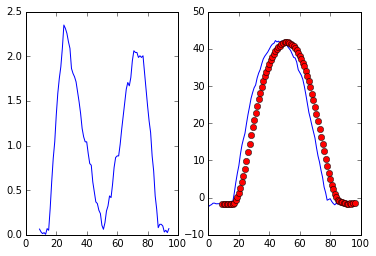

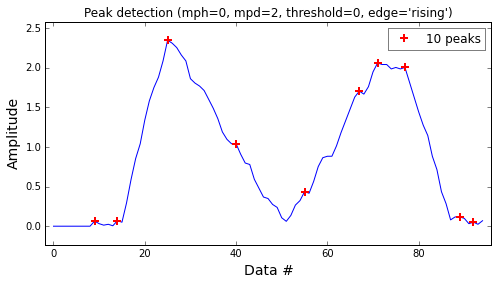

[ 9 14 25 40 55 67 71 77 89 92]
[ 0.0638772   0.06928757  2.3494938   1.041408    0.435273    1.706184
  2.061174    2.00515062  0.11745729  0.0506131 ]


(25, 71)

In [7]:
header_row = ['x', 'h']
data = pd.read_csv('./nb/bubble1.txt', delimiter='\t', names=header_row)
data = data[1:]

x = double(data['x'].values)
y = double(data['h'].values)
q = double(pd.rolling_mean(data['h'], window = 10).values)

plt.subplot(121)
plt.plot(abs(q[0:-2] - q[1:-1]))

plt.subplot(122)
plt.plot(y)
plt.plot(q,'ro')

vector = abs(nan_to_num(q[0:-2] - q[1:-1]))
ind = detect_peaks(vector, mph=0, mpd=2, show=True)
ind_value = zeros(len(ind))
for i in range(len(ind)):
    ind_value[i] = vector[ind[i]]
    
top_idx = ind_value.argsort()[-2:][::-1]
left_idx = ind[min(top_idx)]
right_idx = ind[max(top_idx)]
print(ind)
print (ind_value)
left_idx, right_idx

## Parameter space for the data

Here we have plotted the $\theta$ against $R$ data for our objects. 

(10, 30)

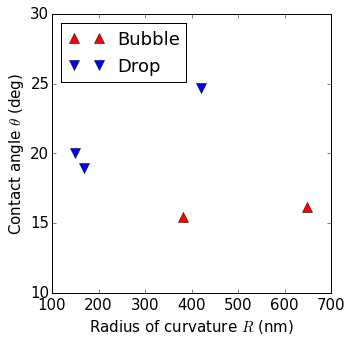

In [8]:
R1, angle1 = fitAngle('./nb/bubble1.txt', windowSize=10)
R3, angle3 = fitAngle('./nb/bubble3.txt', windowSize=10)
R4, angle4 = fitAngle('./nb/drop4.txt', windowSize=10)
R5, angle5 = fitAngle('./nb/drop5.txt', windowSize=10)
R6, angle6 = fitAngle('./nb/drop6.txt', windowSize=5)

plt.figure(figsize=(5,5))
plt.plot([R1, R3], [angle1, angle3], 'r^', markersize=10, label='Bubble')
plt.plot([R4, R5, R6], [angle4, angle5, angle6], 'bv', markersize=10, label='Drop')
plt.xlabel('Radius of curvature $R$ (nm)')
plt.ylabel('Contact angle $\\theta$ (deg)')
plt.rcParams['font.size'] = 15
plt.legend(loc='upper left')
plt.ylim([10, 30])

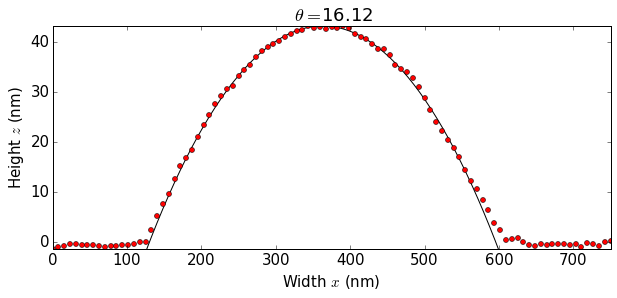

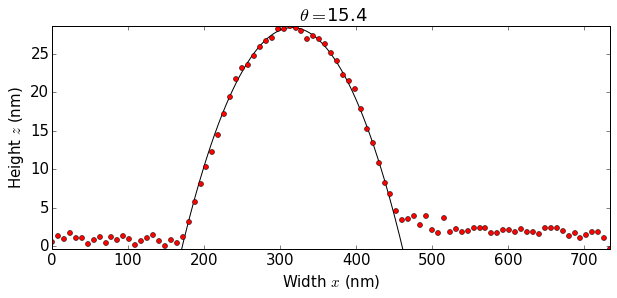

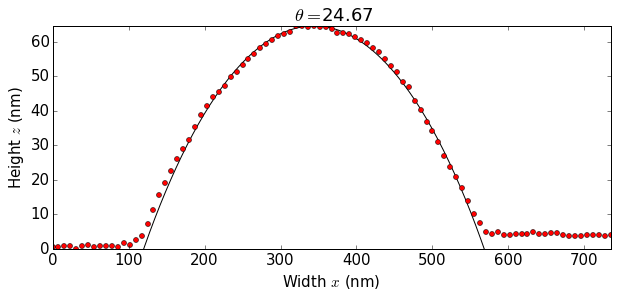

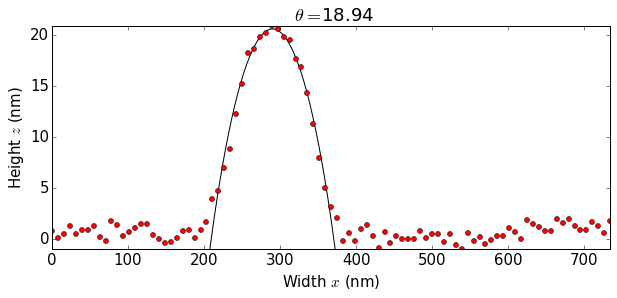

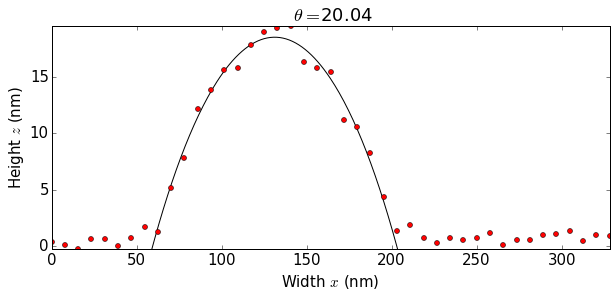

In [9]:
plotObject('./nb/bubble1.txt', windowSize=10)
plotObject('./nb/bubble3.txt', windowSize=10)
plotObject('./nb/drop4.txt', windowSize=10)
plotObject('./nb/drop5.txt', windowSize=10)
plotObject('./nb/drop6.txt', windowSize=5)